In [1]:
# this code uses some scripts from the torchvision repo

# %%shell

# # Download TorchVision repo to use some files from
# # references/detection
# git clone https://github.com/pytorch/vision.git
# cd vision
# git checkout v0.8.2

# cp references/detection/utils.py ../
# cp references/detection/transforms.py ../
# cp references/detection/coco_eval.py ../
# cp references/detection/engine.py ../
# cp references/detection/coco_utils.py ../

In [2]:
import os
import numpy as np

import torch
import torch.utils.data
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# torchvision (v0.8.2) script imports
import utils
import transforms as T
from engine import train_one_epoch, evaluate

from PIL import Image

# Custom Dataset

In [3]:
# download the dataset if not yet

# %%shell

# # download the Penn-Fudan dataset
# wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# # extract it in the current folder
# unzip PennFudanPed.zip

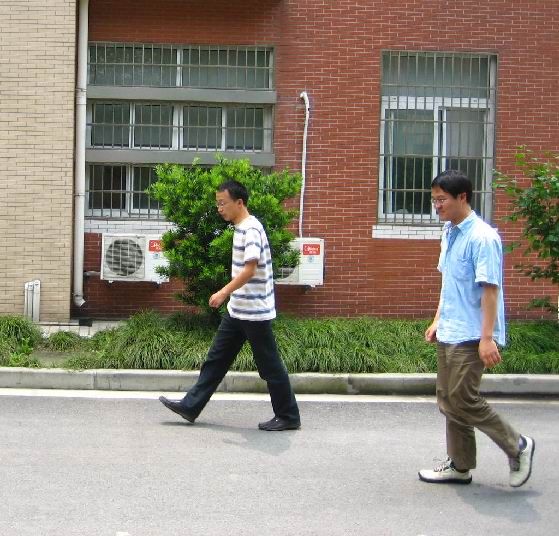

In [4]:
# check an example image data
Image.open('data/PennFudanPed/PNGImages/FudanPed00001.png')

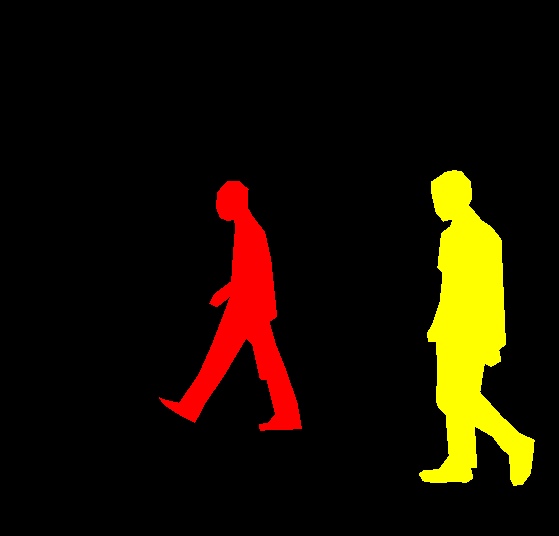

In [5]:
# check the example mask image
mask = Image.open('data/PennFudanPed/PedMasks/FudanPed00001_mask.png')

# color each mask instance differently
mask = mask.convert('P')                # need to convert to P mode first to use putpalette
mask.putpalette([
    0, 0, 0,        # background mask
    255, 0, 0,      # 1st mask - red
    255, 255, 0,    # 2nd mask - yellow
])
mask

In [6]:
# create a custom torch dataset class to load the datas, so that we could return our custom data and target
class PennFudanDataset(torch.utils.data.Dataset):

    def __init__(self, root_path, transforms=None):
        self.root_path = root_path
        self.transforms = transforms

        # load all image filenames and sort
        self.imgs = list(sorted(os.listdir(os.path.join(root_path, "PNGImages"))))  # the PNGImages folder contains each RGB image
        self.masks = list(sorted(os.listdir(os.path.join(root_path, "PedMasks"))))  # the PedMasks folder contains each mask image

    def __getitem__(self, idx):
        # load the image specified by the idx
        img_path = os.path.join(self.root_path, "PNGImages", self.imgs[idx])
        img = Image.open(img_path).convert('RGB')

        # load the mask specified by the idx
        mask_path = os.path.join(self.root_path, "PedMasks", self.masks[idx])
        mask = Image.open(mask_path)  # mask is not RGB image

        # convert PIL image to np array
        mask = np.array(mask)
        # each instance in the mask, e.g. background, person 1, person 2... is encoded as a different color channel
        object_ids = np.unique(mask)
        # background is id 0, remove it
        object_ids = object_ids[1:]

        # split the mask into a set of binary masks (only check the first dimension which is id)
        masks = mask == object_ids[:, None, None]

        # get bounding box coord for each instance mask
        num_objects = len(object_ids)
        boxes = []
        for i in range(num_objects):
            # get all the pixel in this mask which is this instance
            pos = np.where(masks[i])

            # get the bounding box
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        # label tensor for each instance, all instances considered as same class, i.e. = 1
        labels = torch.ones((num_objects, ), dtype=torch.int64)

        # image id of this sample
        image_id = torch.tensor([idx])

        # area of each bounding box
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # assume all instance is not crowd
        iscrowd = torch.zeros((num_objects, ), dtype=torch.int64)

        # construct the target dict to return
        target = {}
        target["boxes"] = boxes                 # bounding boxes coords of each instance                            [N, 4] where N = number of instances
        target["labels"] = labels               # label for eaching bounding box, 0 is background                   [N]
        target["image_id"] = image_id           # uniq image id of this sample
        target["area"] = area                   # areas of each instance bounding box, used for COCO evaluation     [N]
        target["iscrowd"] = iscrowd             # if an instance is iscrow, it will be ignored during evaluation    [N]
        target["masks"] = masks                 # segmantation mask image for each instance                         [N, H, W]

        # if any torch transforms 
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
    
    def __len__(self):
        return len(self.imgs)
        

In [7]:
# create the dataset
dataset = PennFudanDataset('data/PennFudanPed/')

# check one sample
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536>,
 {'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]),
  'labels': tensor([1, 1]),
  'image_id': tensor([0]),
  'area': tensor([35358., 36225.]),
  'iscrowd': tensor([0, 0]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)})

In [8]:
# data transform function
def get_transform(train):
    transforms = []

    # transforms a PIL image to torch tensor
    transforms.append(T.ToTensor())

    # if training, randomly transforms by flipping the data for data augmentation
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))

    return T.Compose(transforms)

In [9]:
# collate function from torchvision
def collate_fn(batch):
    return tuple(zip(*batch))

In [10]:
# create train and test custom datasets, train uses transform
dataset = PennFudanDataset('data/PennFudanPed/', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed/', get_transform(train=False))

# both were created using full data, now split them
torch.manual_seed(42)
indices = torch.randperm(len(dataset)).tolist()  # create random indices list
dataset = torch.utils.data.Subset(dataset, indices[:-50])   # all except 50
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])   # 50 samples

# create data loaders
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Model

In [11]:
# helper function to create a model using a pretrained model
def get_instance_segmentation_model(num_classes):
    # load pretrained Mask R-CNN (instance sgementation) model trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='MaskRCNN_ResNet50_FPN_Weights.DEFAULT')

    # replace the last classifying layer (for the bounding box) on the pretrained model
    in_features = model.roi_heads.box_predictor.cls_score.in_features  # get number of inputs to the classifying layer
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # replace the last classifying layer (for the segmentation mask) on the pretrained model
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels  # get number of inputs to the classifying layer
    hidden_layer = 256  # add a hidden layer for Mask R-CNN
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

# Train

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# dataset is 2 classes only, i.e. background or person (each person in the image is considered as same class)
num_classes = 2

# model
model = get_instance_segmentation_model(num_classes)
model.to(device)

# optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# lr scheduler which decreases lr by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [13]:
num_epochs = 10

for epoch in range(num_epochs):
    # train every epoch, print every 10 iters
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

    # update lr
    lr_scheduler.step()

    # evaluate on test set
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:06:40  lr: 0.000090  loss: 5.6498 (5.6498)  loss_classifier: 0.5706 (0.5706)  loss_box_reg: 0.1633 (0.1633)  loss_mask: 4.9092 (4.9092)  loss_objectness: 0.0052 (0.0052)  loss_rpn_box_reg: 0.0015 (0.0015)  time: 6.6720  data: 0.0290  max mem: 2091
Epoch: [0]  [10/60]  eta: 0:00:46  lr: 0.000936  loss: 1.4801 (2.6619)  loss_classifier: 0.3912 (0.3883)  loss_box_reg: 0.2372 (0.2531)  loss_mask: 0.8742 (1.9889)  loss_objectness: 0.0189 (0.0259)  loss_rpn_box_reg: 0.0045 (0.0056)  time: 0.9303  data: 0.0327  max mem: 2949
Epoch: [0]  [20/60]  eta: 0:00:26  lr: 0.001783  loss: 1.1225 (1.7821)  loss_classifier: 0.2447 (0.2980)  loss_box_reg: 0.2465 (0.2664)  loss_mask: 0.5055 (1.1899)  loss_objectness: 0.0158 (0.0207)  loss_rpn_box_reg: 0.0071 (0.0072)  time: 0.3538  data: 0.0304  max mem: 2949
Epoch: [0]  [30/60]  eta: 0:00:16  lr: 0.002629  loss: 0.5843 (1.3690)  loss_classifier: 0.1320 (0.2292)  loss_box_reg: 0.2179 (0.2434)  loss_mask: 0.2172 (0.8723)  loss_ob

# Prediction

In [14]:
# choose one image from the test set
img, _ = dataset_test[0]

# put model to eval mode
model.eval()

with torch.no_grad():
    prediction = model([img.to(device)])

prediction

[{'boxes': tensor([[232.9706,  85.5622, 314.0323, 353.2772],
          [340.4227, 113.5650, 390.4164, 263.5148],
          [129.3089,  92.2773, 205.5082, 358.4712],
          [ 23.0379,  90.2457, 141.4934, 403.4448],
          [387.5600, 114.5198, 425.8035, 248.1138],
          [  3.3323, 105.3648,  34.5011, 219.7796],
          [302.8521, 111.8689, 330.9430, 252.5055],
          [359.4626, 107.0597, 424.9636, 259.5664]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9974, 0.9951, 0.9943, 0.9942, 0.9802, 0.9621, 0.6841, 0.0504],
         device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 

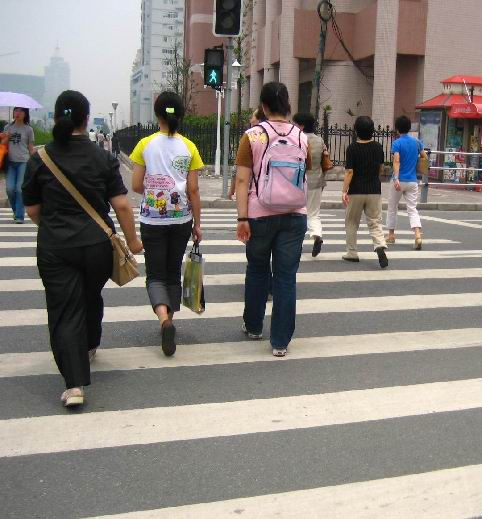

In [15]:
# visualize the image
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

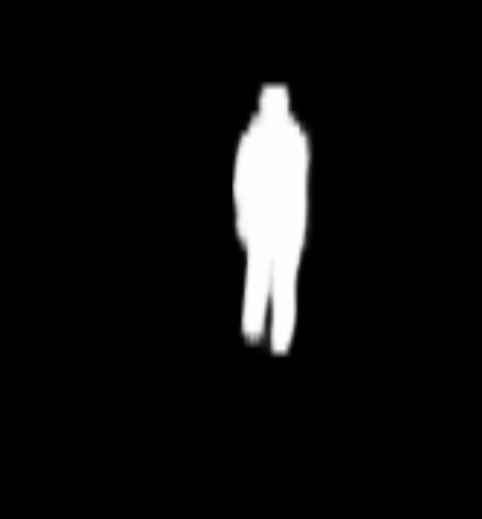

In [16]:
# and segmentation mask
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

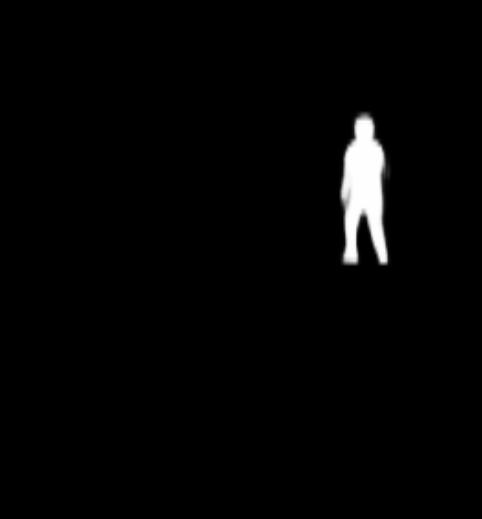

In [17]:
Image.fromarray(prediction[0]['masks'][1, 0].mul(255).byte().cpu().numpy())